In [1]:
# Step 1: Import Required Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
# Step 2: Data Preprocessing

# Step 2.1: Set Up Paths and Parameters
# Define base directory for dataset
base_dir = "E:/DATA SCIENCE/capstone/datasets/Fire and Non fire"
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Parameters for image size and batch processing
IMG_HEIGHT = 64  # Reduced size for faster processing
IMG_WIDTH = 64
BATCH_SIZE = 16  # Reduced batch size

# Step 2.2: Create Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 25919 images belonging to 3 classes.
Found 6479 images belonging to 3 classes.
Found 10500 images belonging to 3 classes.


In [3]:
# Step 3: Model Development

# Step 3.1: Build the Model

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes: fire, non fire, smoke
])

# Step 3.2: Compile the Model

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


C:\Users\home\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
# Step 4: Model Training

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=1)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=1,
    callbacks=[early_stopping]
)

C:\Users\home\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1620/1620 ━━━━━━━━━━━━━━━━━━━━ 1893s 1s/step - accuracy: 0.8400 - loss: 0.4302 - val_accuracy: 0.9156 - val_loss: 0.2548


657/657 ━━━━━━━━━━━━━━━━━━━━ 697s 1s/step - accuracy: 0.8872 - loss: 0.2798
Test Accuracy: 0.89
657/657 ━━━━━━━━━━━━━━━━━━━━ 537s 814ms/step
              precision    recall  f1-score   support

       Smoke       0.33      0.28      0.30      3500
        fire       0.33      0.33      0.33      3500
    non fire       0.34      0.40      0.37      3500

    accuracy                           0.34     10500
   macro avg       0.33      0.34      0.33     10500
weighted avg       0.33      0.34      0.33     10500



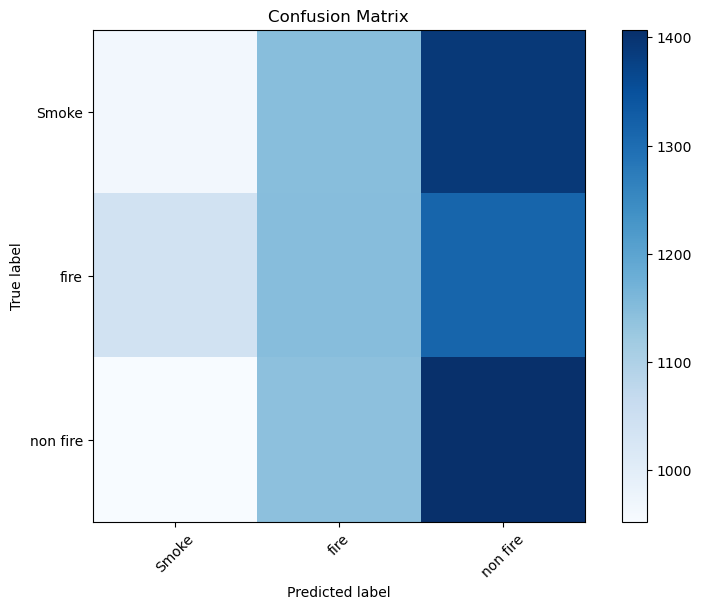

In [5]:
# Step 5: Evaluate the Model

# Evaluate on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Predict on test data
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [6]:
# Step 6: Hyperparameter Tuning with Grid Search

# Define a function to create the model
def create_model(learning_rate=0.001):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Use the SciKeras wrapper
model = KerasClassifier(model=create_model, epochs=1, batch_size=BATCH_SIZE, verbose=1)

# Define parameter grid
param_grid = {'model__learning_rate': [0.001]}

# Setup GridSearchCV with n_jobs=1
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=2)

# Fit the model using grid search
grid_result = grid.fit(train_generator)

# Print the best score and parameters
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

ValueError: 
All the 2 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\home\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 886, in _fit_and_score
    estimator.fit(X_train, **fit_params)
TypeError: KerasClassifier.fit() missing 1 required positional argument: 'y'
